In [1]:
from pathlib import Path
import dotenv
from google import genai
dotenv.load_dotenv()

gem_client = genai.Client()


In [18]:

import base64
from io import BytesIO
from PIL import Image

path = "/home/ubuntu/documents/induction-labs/repos/synth/test_data/pull_main.png"
img = Image.open(path)

def pil_to_b64(image: Image.Image, fmt: str = "PNG") -> str:
    buf = BytesIO()
    image.save(buf, format=fmt)
    return base64.b64encode(buf.getvalue()).decode("ascii")

image_b64 = pil_to_b64(img, fmt="PNG")
data_uri = f"data:image/png;base64,{image_b64}"


In [37]:
from litellm import completion 
import os


for _ in range(2):
    response = completion(
        model="gpt-4o",
        messages=[
            # System Message
            {
                "role": "system",
                "content": [
                    {
                        "type": "text",
                        "text": "Here is the full text of a complex legal agreement"
                        * 400,
                    }
                ],
            },
            # marked for caching with the cache_control parameter, so that this checkpoint can read from the previous cache.
            {
                "role": "user",
                "content": [
                    # {
                    #     "type": "text",
                    #     "text": "What are the key terms and conditions in this agreement?",
                    # },
                     {
                        "type": "image_url",
                        "image_url": {
                            "url": data_uri,
                            "detail": "high",
                        },
                    },
                ],
                
            },
            {
                "role": "assistant",
                "content": "Certainly! the key terms and conditions are the following: the contract is 1 year long for $10/mo",
            },
            # The final turn is marked with cache-control, for continuing in followups.
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "What are the key terms and conditions in this agreement?",
                    "cache_control": {"type": "ephemeral"},
                    }
                ],
            },
        ],
        temperature=0.2,
        max_tokens=10,
    )

print("response=", response)
print("response.usage=", response.usage)

assert "prompt_tokens_details" in response.usage
assert response.usage.prompt_tokens_details.cached_tokens > 0

response= ModelResponse(id='chatcmpl-C3bQAfhY830CqJslojY3twf4tXqz8', created=1754974866, model='gpt-4o-2024-08-06', object='chat.completion', system_fingerprint='fp_ff25b2783a', choices=[Choices(finish_reason='length', index=0, message=Message(content='The image is a stylized illustration of a character', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[]), provider_specific_fields={})], usage=Usage(completion_tokens=10, prompt_tokens=5157, total_tokens=5167, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None)), service_tier='default')
response.usage= Usage(completion_tokens=10, prompt_tokens=5157, total_tokens=5167, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_predict

AssertionError: 

In [ ]:
# pip install --upgrade openai pillow
from openai import OpenAI

client = OpenAI()  # uses OPENAI_API_KEY from env

# --- load + b64 encode image ---

# --- shared conversation (identical prefix to benefit from prompt caching) ---
conversation = [
    {"role": "system",
     "content": [{"type": "input_text",
                  "text": "Here is the full text of a complex legal agreement"* 400}]},
    {"role": "user",
     "content": [
        #  {"type": "input_image", "image_url": data_uri},
         {"type": "input_text",
          "text": "What are the key terms and conditions in this agreement?" },
     ]},
    {"role": "assistant",
     "content": [{"type": "output_text",
                  "text": "Certainly! the key terms and conditions are the following: the contract is 1 year long for $10/mo"}]},
    {"role": "user",
     "content": [{"type": "input_text",
                  "text": "What are the key terms and conditions in this agreement?"}]},
]
resp = None
for i in range(2):
    resp = client.responses.create(
        model="gpt-4o",
        input=conversation,
        extra_body={
            "prompt_cache_key": "test_prompt_cache_key",  # use a fixed key to hit the cache
        },
        max_output_tokens=1000,  # limit output length
    )

    print(f"\n--- call {i+1} ---")
    print("text:", resp)
    print("usage:", resp.usage)

    # prompt caching visibility

assert resp.usage is not None
assert resp.usage.input_tokens_details is not None
assert (resp.usage.input_tokens_details.cached_tokens or 0) > 0, \
    "cached_tokens == 0 (need a >=1024-token shared prefix to hit the cache)"



--- call 1 ---
text: To accurately identify the key terms and conditions of an agreement, I would typically highlight sections related to parties involved, duration, payment terms, obligations, termination clauses, confidentiality, and dispute resolution. However, since I can't see the actual document, you would need to look for these elements within the text.

If you have specific sections or clauses you want reviewed, feel free to share, and I can help explain or clarify them.
usage: ResponseUsage(input_tokens=4063, input_tokens_details=InputTokensDetails(cached_tokens=3840), output_tokens=86, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=4149)

--- call 2 ---
text: To help you effectively, I'd need some details about the agreement's specific sections. Generally, key terms and conditions in a legal agreement might include:

1. **Parties Involved**: Who is entering the agreement.
2. **Definitions**: Key terms defined within the agreement.
3. **Duration**

AssertionError: cached_tokens == 0 (need a >=1024-token shared prefix to hit the cache)

In [ ]:
# actions_path = Path("../../../test_data/action_capture_jeffrey_2025-06-27_121528_AX8OE_action_capture_000000.jsonl")
# actions = load_actions(actions_path)
# actions
from synth.recordings.synth_captions_generated_samples import get_actions

from synth.recordings.gemini_process import load_metadata

actions_path = "induction-labs-data-ext/action_capture/aryan_91532/2025-07-08_160952_VX5RU"
video_metadata = load_metadata(actions_path)
print(video_metadata)

raw_actions = get_actions(actions_path)
raw_actions


timestamp=1752005396.35 username='aryan_91532' screen_info=ScreenInfo(video_width=3420, video_height=2214, logical_pixel_ratio=2.0, logical_pixel_width=1710, logical_pixel_height=1107) video_segment_buffer_length=30 time_base=Fraction(1, 1000000)


In [15]:
import pandas as pd


# raw_actions = pd.DataFrame(raw_actions)
# raw_actions = raw_actions[raw_actions["timestamp"] >=1751949210.534025]
raw_actions = [k for k in raw_actions if k["timestamp"] >= 1752772573.455751]
raw_actions

[{'action': {'action': 'key_button', 'key': 'right', 'is_down': True},
  'timestamp': 1752772573.6516492},
 {'action': {'action': 'key_button', 'key': 'right', 'is_down': False},
  'timestamp': 1752772573.730971},
 {'action': {'action': 'key_button', 'key': 'right', 'is_down': True},
  'timestamp': 1752772574.111154},
 {'action': {'action': 'key_button', 'key': 'right', 'is_down': False},
  'timestamp': 1752772574.210491},
 {'action': {'action': 'key_button', 'key': 'right', 'is_down': True},
  'timestamp': 1752772574.612188},
 {'action': {'action': 'key_button', 'key': 'right', 'is_down': False},
  'timestamp': 1752772574.7163453},
 {'action': {'action': 'key_button', 'key': 'right', 'is_down': True},
  'timestamp': 1752772575.001641},
 {'action': {'action': 'key_button', 'key': 'right', 'is_down': False},
  'timestamp': 1752772575.0746183},
 {'action': {'action': 'key_button', 'key': 'right', 'is_down': True},
  'timestamp': 1752772575.303312},
 {'action': {'action': 'key_button', 'k

In [ ]:
import importlib
import synth.recordings.parse_actions
import synth.recordings.gemini_process
import synth.recordings.transform_coordinates

importlib.reload(synth.recordings.parse_actions)
importlib.reload(synth.recordings.gemini_process)
importlib.reload(synth.recordings.transform_coordinates)

from synth.recordings.parse_actions import parse_actions, Action, ScrollAction, Point, ClickAction
from synth.recordings.gemini_process import combine_scroll_actions,  combine_actions, get_target_resolution
from synth.recordings.transform_coordinates import (
    RecordingMetadata,
    transform_action_coords_list,
)
parsed_actions = parse_actions(raw_actions)
target_resolution = get_target_resolution(video_metadata)
transformed_actions = transform_action_coords_list(
    parsed_actions,
    target_resolution,
    video_metadata
)

combined_actions = combine_actions(parsed_actions)
print(len(combined_actions))


26881


[Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=1360, y=140)), timestamp=1752005396.249767, end_timestamp=1752005396.299447),
 Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=460, y=549)), timestamp=1752005398.899805, end_timestamp=1752005398.96613),
 Action(action=HotkeyAction(action_type='hotkey', modifiers={'cmd'}, key='w'), timestamp=1752005399.2635462, end_timestamp=1752005399.3316212),
 Action(action=HotkeyAction(action_type='hotkey', modifiers={'shift', 'cmd'}, key='-'), timestamp=1752005401.710428, end_timestamp=1752005401.754014),
 Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=1327, y=69)), timestamp=1752005403.366111, end_timestamp=1752005403.3993292),
 Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=1113, y=68)), timestamp=1752005405.366131, end_timestamp=1752005405.449429),
 Action(action=HotkeyAction(action_type='hotkey', modifiers={'cmd'}, key='w'), t

<Axes: title={'center': 'Action Timestamps'}, xlabel='Index', ylabel='Timestamp'>

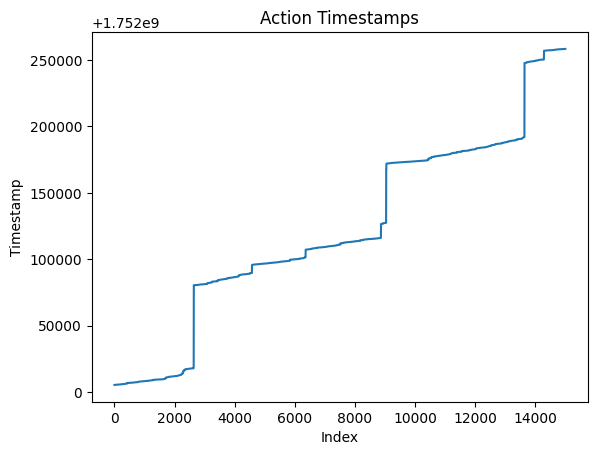

In [34]:
combined_actions = combined_actions[:15000]
action_timestamps = [a.timestamp for a in combined_actions]

# Plot the action timestamps
import matplotlib.pyplot as plt
series = pd.Series(action_timestamps)
series.plot(title="Action Timestamps", xlabel="Index", ylabel="Timestamp")

count    1723.000000
mean        8.705746
std        13.448742
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       159.000000
dtype: float64
1723


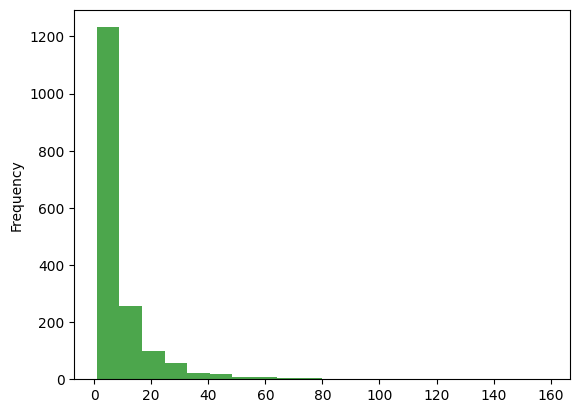

In [35]:
from synth.recordings.gemini_process import segment_actions_by_time_gaps
import pandas as pd
segmented_actions = segment_actions_by_time_gaps(combined_actions, gap_threshold=4.0)
segmented_lengths = [len(segment) for segment in segmented_actions]
segmented_lengths = pd.Series(segmented_lengths)
print(segmented_lengths.describe())
print(len(segmented_actions))
import matplotlib.pyplot as plt
segmented_lengths.plot(kind='hist', bins=20, alpha=0.7, color='green')
plt.show()

In [5]:

import pandas as pd
actions_df = pd.DataFrame([{"action": a, "start_timestamp": a.timestamp, 
                            "end_timestamp": a.end_timestamp, 
                            "action_type": a.action.action_type
                            } for a in combined_actions])
actions_df.head()


actions_df['action_type'].value_counts()
# actions_df.head().iloc[0]['start_timestamp']
# actions_df['action'].iloc[0]

action_type
hotkey          200
click           172
scroll          111
type             76
left_double      24
drag              3
right_single      1
Name: count, dtype: int64

In [36]:
import synth.recordings.gemini_process
import synth.recordings.parse_actions
import importlib
importlib.reload(synth.recordings.parse_actions)
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.gemini_process import get_timesteps_range, get_target_resolution
action_set = segmented_actions[-1][0:10]
start_time, timesteps = get_timesteps_range(action_set)
print(timesteps)
action_set

[1752258387.791624, 1752258389.6083431]


[Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=712, y=1091)), timestamp=1752258387.4750452, end_timestamp=1752258387.591624),
 Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=731, y=694)), timestamp=1752258389.391974, end_timestamp=1752258389.408343)]

In [37]:
import importlib
import synth.recordings.gemini_process
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.gemini_process import get_frames_at_timestamps, get_target_resolution

frames = get_frames_at_timestamps(actions_path, video_metadata, [start_time, *timesteps], target_resolution=get_target_resolution(video_metadata) )

Timestamp 1752258387.2750452 recording start time 1752005396.35. rel_timestamp=252990.92504525185
Timestamp 1752258387.791624 recording start time 1752005396.35. rel_timestamp=252991.44162416458
Timestamp 1752258389.6083431 recording start time 1752005396.35. rel_timestamp=252993.25834321976


FileNotFoundError: [Errno 2] No such file or directory: 'induction-labs-data-ext/action_capture/aryan_91532/2025-07-08_160952_VX5RU/screen_capture_008433.mp4'

In [40]:

from synapse.video_loader.video import download_video_with_ffmpeg_copy
from pathlib import Path
from synapse.video_loader.video import VideoMetadataFetcher
import av

video_output_path = Path("../../../test_data/test_video.mp4")
download_video_with_ffmpeg_copy(
    source_path="gs://induction-labs-data-ext/action_capture/aryan_91532/2025-07-08_160952_VX5RU/screen_capture_000414.mp4",
    dest_path=video_output_path.as_posix(),
    ffmpeg_path="/nix/store/q7j5awbg80d38p9my5b5zgn0xadgvbmb-ffmpeg-7.1.1-bin/bin/ffmpeg"
)
video_container = av.open(video_output_path.as_posix())
container_metadata = VideoMetadataFetcher.get_video_metadata(
                video_container.streams.video[0]
            )

# # video_path = Path("../../../test_data/action_capture_jeffrey_2025-06-27_121528_AX8OE_screen_capture_000084.mp4")
start_time = float(container_metadata.start_pts * container_metadata.time_base)
end_time = float(container_metadata.end_pts * container_metadata.time_base) 

time_bounds = (start_time, end_time)
print(time_bounds)
print((end_time - video_metadata.timestamp)/30)

(1752017816.371, 1752017846.856214)
415.01687380472816


In [31]:
# Filter df for actions within the video time bounds
start, end = time_bounds
filtered_actions_df = actions_df[(actions_df['start_timestamp'] >= start) & (actions_df['end_timestamp'] <= end)]
filtered_actions = filtered_actions_df["action"].tolist()
# first_timestamp = int(filtered_actions[0][2]) if len(filtered_actions) > 0 else 0
# for k in filtered_actions:
    # k[2] = k[2]- first_timestamp
filtered_actions

[Action(action=TypeAction(action_type='type', content='npm i -g @'), timestamp=1754858185.7871203, end_timestamp=1754858187.9271371),
 Action(action=HotkeyAction(action_type='hotkey', modifiers={'cmd'}, key='`'), timestamp=1754858188.175196, end_timestamp=1754858188.218485),
 Action(action=TypeAction(action_type='type', content='npm i -'), timestamp=1754858188.919529, end_timestamp=1754858189.501357),
 Action(action=HotkeyAction(action_type='hotkey', modifiers=set(), key='right'), timestamp=1754858189.7006621, end_timestamp=1754858189.7006621),
 Action(action=LeftDoubleAction(action_type='left_double', modifiers=set(), point=Point(x=425, y=784)), timestamp=1754858190.665126, end_timestamp=1754858190.8483143),
 Action(action=LeftDoubleAction(action_type='left_double', modifiers=set(), point=Point(x=425, y=784)), timestamp=1754858190.881437, end_timestamp=1754858190.94914),
 Action(action=ClickAction(action_type='click', modifiers=set(), point=Point(x=333, y=781)), timestamp=1754858191.5

Frame 0 metadata timestamp=1751923223.68813 original_timestamp=1751923223.672393 video_path='gs://induction-labs-data-ext/action_capture/aryan_91532/2025-07-07_170814_A2QD2/screen_capture_000024.mp4'


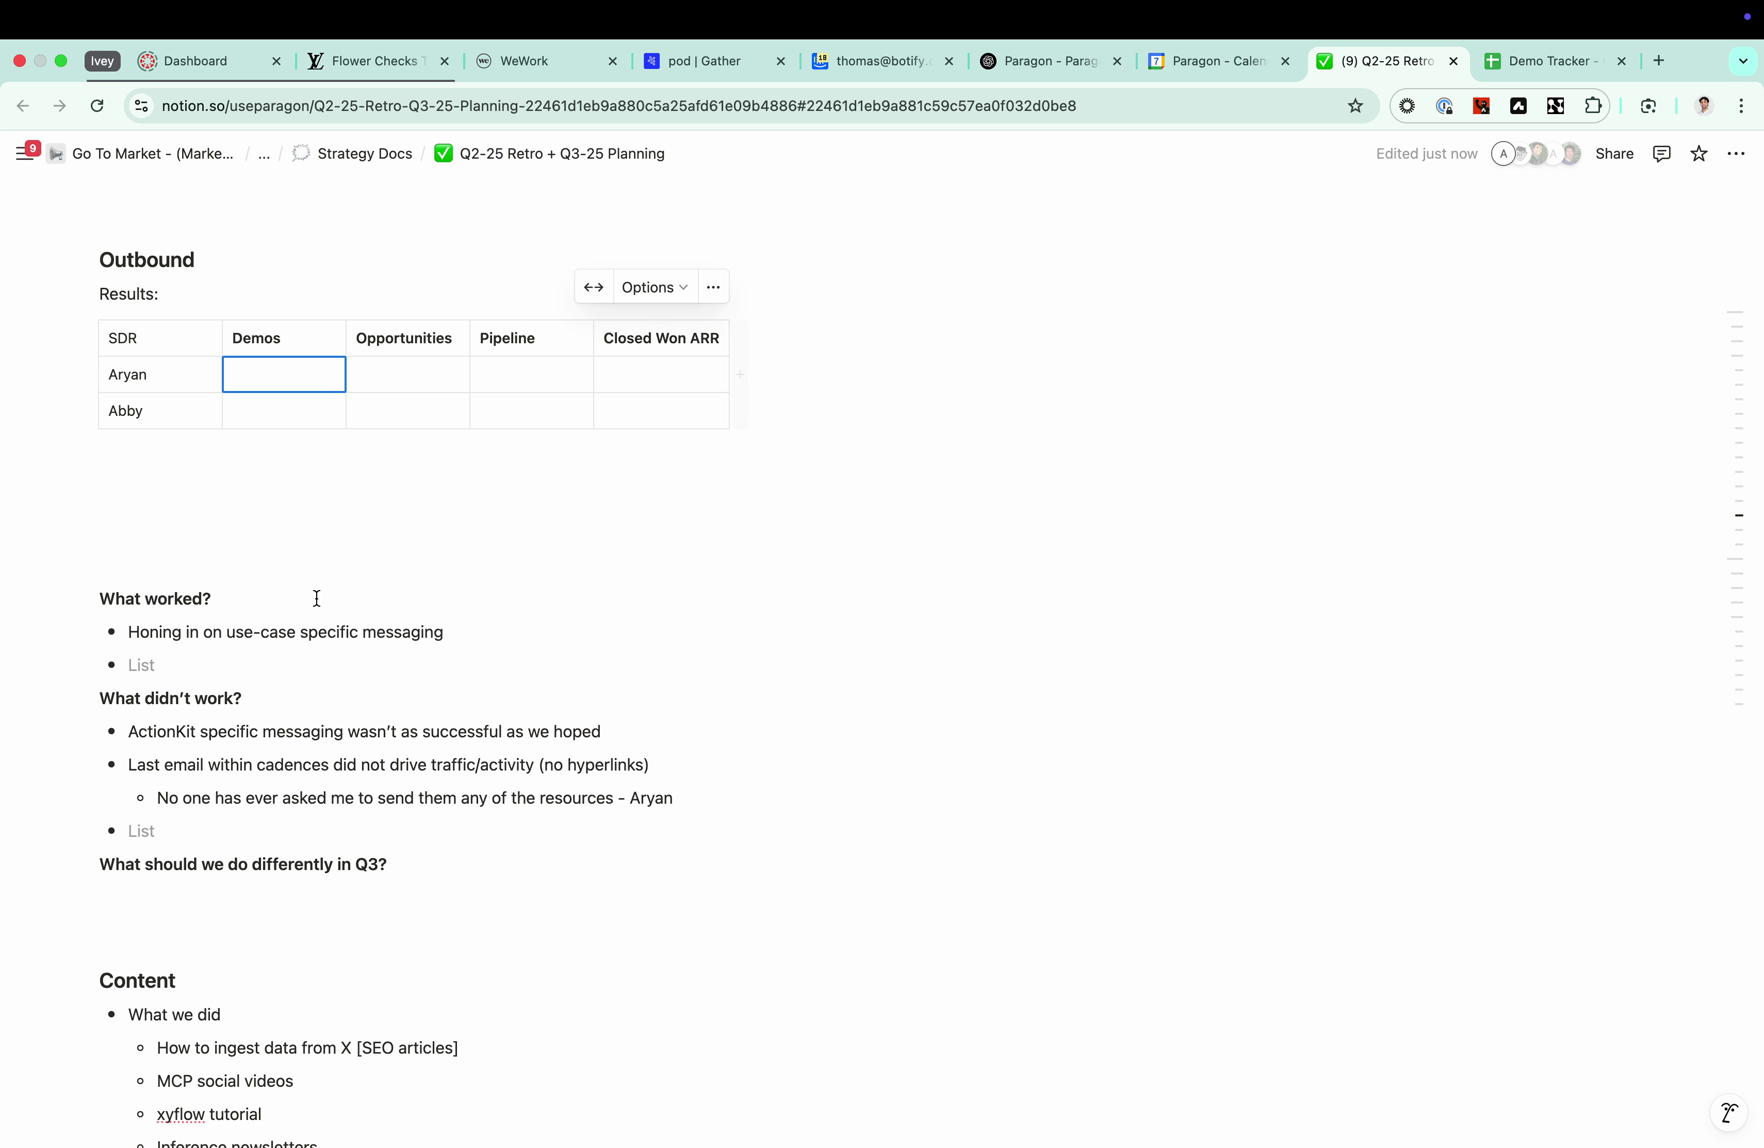

In [11]:
import importlib
import synth.recordings.synth_captions_generated_samples
importlib.reload(synth.recordings.synth_captions_generated_samples)
from synth.recordings.synth_captions_generated_samples import extract_frames_by_pts
import synth.recordings.gemini_process
import synth.recordings.parse_actions
importlib.reload(synth.recordings.parse_actions)
importlib.reload(synth.recordings.gemini_process)
from synth.recordings.gemini_process import get_timesteps_range

# action_range = (0,5)
# actions = filtered_actions[action_range[0]:action_range[1]]

# before_timestamp, action_end_timestamps = get_timesteps_range(actions)

# print(action_before)
# for action in actions:
#     print(action)

# frames = extract_frames_by_pts(video_output_path, [before_timestamp, *action_end_timestamps])
i=0
frame, metadata = frames[0]
print(f"Frame {i} metadata {metadata}")
frame

In [12]:
from PIL import Image, ImageDraw
from synth.recordings.gemini_process import transform_coordinates
# i = 1


action = action_set[i]

i = i + 1
frame, metadata = frames[i]
print(f"Frame {i} at {metadata}")
print(f"Action: {action}")
LOGICAL_RATIO = 2.0
if hasattr(action.action, 'point'):
  # print(f"Click point: {action.action.point}")
  draw = ImageDraw.Draw(frame)
  
  coords = transform_coordinates(
    action.action.point,
    video_metadata.screen_info.logical_pixel_width,
    video_metadata.screen_info.logical_pixel_height,
    frame.size[0],
    frame.size[1],
  )
  x = coords.x
  y = coords.y
  print(f"Drawing circle at ({x}, {y})")
  # Draw a circle around the click point
  draw.ellipse((x - 10, y - 10, x + 10, y + 10), fill="red",)
# frame

frame

ImportError: cannot import name 'transform_coordinates' from 'synth.recordings.gemini_process' (/home/ubuntu/documents/induction-labs/repos/synth/src/synth/recordings/gemini_process.py)

In [111]:
from synth.recordings.image_utils import pil_to_bytes
from google.genai import types

image_action_pairs = []
for i, action in enumerate(actions):
    image_action_pairs.append(action.dump_to_text())
    image_action_pairs.append(
        types.Part.from_bytes(
            data=pil_to_bytes(frames[i+1], format='PNG'),
            mime_type='image/png'
        )
    )
contents =[
    "The following are screenshots and the actions a user took from a video recording. Analyze what action the user took in the screenshots and then write a plausible instruction that would result in the behaviour shown in the screenshots.",
    types.Part.from_bytes(
            data=pil_to_bytes(frames[0], format='PNG'),
            mime_type='image/png'
        ),
        *image_action_pairs,
        """After reviewing the screenshots and actions, end your response with:\n### Instruction: <instruction>""",
  ]
print(contents)
response = gem_client.models.generate_content(
  model="gemini-2.5-pro",
  contents=contents 
)
print(response)


['The following are screenshots and the actions a user took from a video recording. Analyze what action the user took in the screenshots and then write a plausible instruction that would result in the behaviour shown in the screenshots.', Part(
  inline_data=Blob(
    data=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0b@\x00\x00\x07\x08\x08\x02\x00\x00\x00 \x86\xd7B\x00\x01\x00\x00IDATx\x9c\xec}w\x98\x1c\xc5\xd1wU\xf5\xcc\xee%\xdd)\xe7\x88\x12\x8a\x08\x14\x11\x02\x83\r/&\x89`\xa2\xc9`\x93^\xbf\xd8$\x13\xfc\x11\x8d\xc96\x18c\xc0\x98\x0c\xc6\xd8\x06\x93s4...',
    mime_type='image/png'
  )
), "click(point='<point>690 288</point>')", Part(
  inline_data=Blob(
    data=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0b@\x00\x00\x07\x08\x08\x02\x00\x00\x00 \x86\xd7B\x00\x01\x00\x00IDATx\x9c\xec}w\xa0\x15\xc5\xf5\xff93\xbb\xf7\xbe\xc6{\xf4^\x05\xa4\t"\x02\xa2\xa2Q\xa31F\xc5n\x8a5M\xa3&\xc6\x1a5~\x93Xb%\x1ac\x89&Q\xa3\x89&\xf9\xaa\x89...',
    mime_type='image/png'
  )
), "type(content='Lite

In [112]:
from synth.recordings.synth_captions_generated_samples import PROMPT_WITHOUT_NEXT
text_prompt = PROMPT_WITHOUT_NEXT.format(
  instruction="On line 22, fix the type hint error by wrapping the dimension `3` in the `tuple` with `Literal`.",
  old_turns=[],
  new_action=actions[0].dump_to_text()
)

print(text_prompt)

thoughts_content = [
  text_prompt,
  types.Part.from_bytes(
      data=pil_to_bytes(frames[0], format='PNG'),
      mime_type='image/png'
  ),
  types.Part.from_bytes(
      data=pil_to_bytes(frames[1], format='PNG'),
      mime_type='image/png'
  ),
]

response = gem_client.models.generate_content(
    model="gemini-2.5-flash",
    contents=thoughts_content
)
response

## Instruction
I'm trying to simulate a user's internal monologue while they perform computer-related tasks. Please write, in the user's voice as an internal monologue, the reasoning that would lead the user to believe that the given action was the correct one to take to complete their task.
Write in the future tense (i.e., "I'll do X") and in a simple, concise tone. It should only be a few sentences long, no Markdown. It should be written like the user's internal monologue, ONLY for the action just taken, but can allude to next steps or refer previous steps.
You will also be provided the action that the user took at the given screenshot. The internal monologue should motivate why the given specific action is a good one, and be specific and provide insight into how to solve the given task.
Don't use fancy words or refer to objects in the physical world (such as "flicking a mouse" or "since I'm already using my mouse"). Include text they typed or keyboard shortcuts pressed in the reason

GenerateContentResponse(
  automatic_function_calling_history=[],
  candidates=[
    Candidate(
      content=Content(
        parts=[
          Part(
            text="I need to edit line 22 to fix the type hint error. The task specifies I need to wrap the `3` in `tuple` with `Literal`. To do that, I'll first place my cursor right before the `3` so I can start typing. I'll click right there."
          ),
        ],
        role='model'
      ),
      finish_reason=<FinishReason.STOP: 'STOP'>,
      index=0
    ),
  ],
  model_version='gemini-2.5-flash',
  sdk_http_response=HttpResponse(
    headers=<dict len=11>
  ),
  usage_metadata=GenerateContentResponseUsageMetadata(
    candidates_token_count=64,
    prompt_token_count=967,
    prompt_tokens_details=[
      ModalityTokenCount(
        modality=<MediaModality.TEXT: 'TEXT'>,
        token_count=451
      ),
      ModalityTokenCount(
        modality=<MediaModality.IMAGE: 'IMAGE'>,
        token_count=516
      ),
    ],
    though

In [14]:
from smart_open import open

with open("gs://induction-labs/passive_data/2025-08-09/first_test_batch/samples.json") as f:
    samples = json.load(f)

samples_df = pd.DataFrame(samples)



samples_df[2:4]
# samples_df.to_json("gs://induction-labs/passive_data/2025-08-09/first_test_batch/samples.jsonl", lines=True, orient="records")

,attempt_id,eval_task_id,actions,thinking,instruction,video_path,trajectory_length,source_dir
2,jZcjcDWgItYw,jZcjcDWgItYw,"[click(point='<point>178 509</point>'), scroll...","[, , , , , ]","Open the `Dockerfile`, and then in the termina...",gs://induction-labs-data-ext/action_capture/je...,6,gs://induction-labs-data-ext/action_capture/je...
3,WWl8QvvQuRIn,WWl8QvvQuRIn,"[click(point='<point>1367 463</point>'), hotke...","[, , , , , ]","To investigate the installation failure, open ...",gs://induction-labs-data-ext/action_capture/je...,6,gs://induction-labs-data-ext/action_capture/je...
